Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [184]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
surface_files = [
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
]

obspack_files = {}
for f in surface_files:
    stn = os.path.basename(f).split('_')[1]
    obspack_files[stn] = os.path.basename(f)

### Contribution details
- 521 Obspack netcdf files (e.g. mlo_surface-flask_1_representative.nc) each with all 10 tracers
- (ObsPack 7.0 has 524 records)
- 32 gridded mole fraction files (annual 1989-2020)

In [189]:
droot = "/glade/p/eol/stephens/longcoll/apo-forward-data/TM5-NOAA"
#droot = "/glade/p/eol/stephens/longcoll/apo-simulation-data/CT_TM5"

path = f"{droot}/{obspack_files['cba']}"
print(path)
ds = xr.open_dataset(path)
droplist = ['time_components','solartime_components']
ds = ds.drop(droplist)
df = ds.to_dataframe()

# Andy's time_components are all zeros, have to get from ObsPack
path = f"{obspack_dir}/{obspack_files['cba']}"
print(path)
tc = xr.open_dataset(path)['time_components']
tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
#tc.drop('obs',axis=1)
tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
df['time'] = pd.to_datetime(tc)
df = df.set_index('time')
#df = df.dropna()
df

# kluge - need to make station name dynamic and allow any number of stations
path = f"{droot}/{obspack_files['psa']}"
print(path)
ds2 = xr.open_dataset(path)
ds2 = ds2.drop(droplist)
df2 = ds2.to_dataframe()
df2

# Andy's time_components are all zeros, have to get from ObsPack
path = f"{obspack_dir}/{obspack_files['psa']}"
print(path)
tc2 = xr.open_dataset(path)['time_components']
tc2 = tc2.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
#tc.drop('obs',axis=1)
tc2.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
df2['time'] = pd.to_datetime(tc2)
df2 = df2.set_index('time')
#df2 = df2.dropna()
df2

/glade/p/eol/stephens/longcoll/apo-forward-data/TM5-NOAA/co2_cba_surface-flask_4_representative.nc
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cba_surface-flask_4_representative.nc
/glade/p/eol/stephens/longcoll/apo-forward-data/TM5-NOAA/co2_psa_surface-flask_4_representative.nc
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_psa_surface-flask_4_representative.nc


<xarray.Dataset>
Dimensions:            (obs: 553)
Dimensions without coordinates: obs
Data variables: (12/26)
    time               (obs) datetime64[ns] 1999-11-11T11:11:11 ... 1999-11-1...
    time_decimal       (obs) float32 2e+03 2e+03 2e+03 ... 2e+03 2e+03 2e+03
    value              (obs) float32 0.0003517 0.0003497 ... 0.0004007 0.0004015
    latitude           (obs) float32 55.21 55.21 55.21 ... 55.21 55.21 55.21
    longitude          (obs) float32 -162.7 -162.7 -162.7 ... -162.7 -162.7
    altitude           (obs) float32 31.34 31.34 31.34 ... 31.34 31.34 31.34
    ...                 ...
    u                  (obs) float32 15.62 16.39 -0.4666 ... 27.98 45.66 -22.2
    v                  (obs) float32 6.85 -20.53 8.55 ... -35.12 5.979 -83.52
    blh                (obs) float32 207.4 258.4 270.5 ... 431.9 818.5 1.159e+03
    q                  (obs) float32 0.007008 0.006952 ... 0.004265 0.00181
    temperature        (obs) float32 283.1 284.4 282.4 ... 284.8 278.8 269.1
    pressure           (obs) float32 1.009e+05 1.016e+05 ... 1.008e+05 9.976e+04
Attributes: (12/137)
    carbontracker_notes:                          This file contains observed...
    site_code:                                    CBA
    site_name:                                    Cold Bay, Alaska
    site_country:                                 United States
    site_country_flag:                            UNST0001.GIF
    site_latitude:                                55.21
    ...                                           ...
    carbontracker_email:                          carbontracker.team@noaa.gov
    carbontracker_url:                            http://carbontracker.noaa.gov
    carbontracker_institution:                    NOAA Earth System Research ...
    conventions:                                  CF-1.5
    carbontracker_history:                        Created on Tue Jul 19 2022 ...
    carbontracker_source:                         CarbonTracker release apo

/glade/p/eol/stephens/longcoll/apo-forward-data/TM5-NOAA/co2_cba_surface-flask_4_representative.nc
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cba_surface-flask_4_representative.nc
/glade/p/eol/stephens/longcoll/apo-forward-data/TM5-NOAA/co2_psa_surface-flask_4_representative.nc
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_psa_surface-flask_4_representative.nc


,time_decimal,value,latitude,longitude,altitude,obs_flag,obspack_id,sampling_strategy,apo_jena,o2_cesm,...,co2_oco2mip,co2_gridfed,o2_gridfed,co2bg,u,v,blh,q,temperature,pressure
time,,,,,,,,,,,,,,,,,,,,,
1996-09-06 02:00:00,1999.861572,0.000361,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,400.0,395.388214,...,400.0,421.904449,369.651367,400.0,-35.867054,-8.819005,298.480713,0.002474,269.240143,97962.203125
1996-09-09 09:38:00,1999.861572,0.000361,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,400.0,394.909149,...,400.0,421.908386,369.645660,400.0,-31.517355,-18.941076,407.329773,0.002385,268.566925,97136.968750
1996-09-20 22:05:00,1999.861572,0.000361,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,400.0,396.674713,...,400.0,422.114594,369.360291,400.0,-14.682441,-19.451160,175.344910,0.003262,271.253723,96109.945312
1996-09-29 20:53:00,1999.861572,0.000361,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,400.0,398.221100,...,400.0,422.118835,369.354126,400.0,-14.343469,-37.103409,188.330109,0.003537,271.855835,94587.343750
1996-10-08 22:20:00,1999.861572,0.000361,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,400.0,396.139648,...,400.0,422.148773,369.312317,400.0,-3.586975,-19.343405,334.989929,0.002339,267.835266,94780.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17 15:00:00,1999.861572,0.000401,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.701219,-13.098254,137.736618,0.003544,273.178650,98617.187500
2020-09-30 13:20:00,1999.861572,0.000404,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.474545,23.958244,208.895645,0.002536,272.248810,95307.492188
2020-10-14 13:40:00,1999.861572,0.000404,-64.7742,-64.052696,20.0,0.0,b'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18...,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-19.448586,-3.515644,225.519623,0.002702,272.082062,95083.148438


In [179]:
# subtract off background value

sno_vars = [
    'apo_jena',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

for v in sno_vars:
    df[v]=df[v]-400.0
    df2[v]=df2[v]-400.0

In [180]:
# add derived APO variables

df['apo_cesm'] = util.compute_apo (
    o2=df['o2_cesm'],
    co2=df['co2_cesm'],
    n2=df['n2_cesm']
)

df['apo_diss'] = util.compute_apo (
    o2=df['o2_gk01r16'],
    co2=df['co2_somffn'],
    n2=df['n2_era']
)

df['apo_gridfed'] = util.compute_apo (
    o2=df['o2_gridfed'],
    co2=df['co2_gridfed'],
    n2=0.0
)

df['apo_oco2mip'] = util.compute_apo (
    o2=df['co2_oco2mip'] * -1.4,
    co2=df['co2_oco2mip'],
    n2=0.0
)

# kluge - need to make station name dynamic and allow any number of stations
df2['apo_cesm'] = util.compute_apo (
    o2=df2['o2_cesm'],
    co2=df2['co2_cesm'],
    n2=df2['n2_cesm']
)

df2['apo_diss'] = util.compute_apo (
    o2=df2['o2_gk01r16'],
    co2=df2['co2_somffn'],
    n2=df2['n2_era']
)

df2['apo_gridfed'] = util.compute_apo (
    o2=df2['o2_gridfed'],
    co2=df2['co2_gridfed'],
    n2=0.0
)

df2['apo_oco2mip'] = util.compute_apo (
    o2=df2['co2_oco2mip'] * -1.4,
    co2=df2['co2_oco2mip'],
    n2=0.0
)

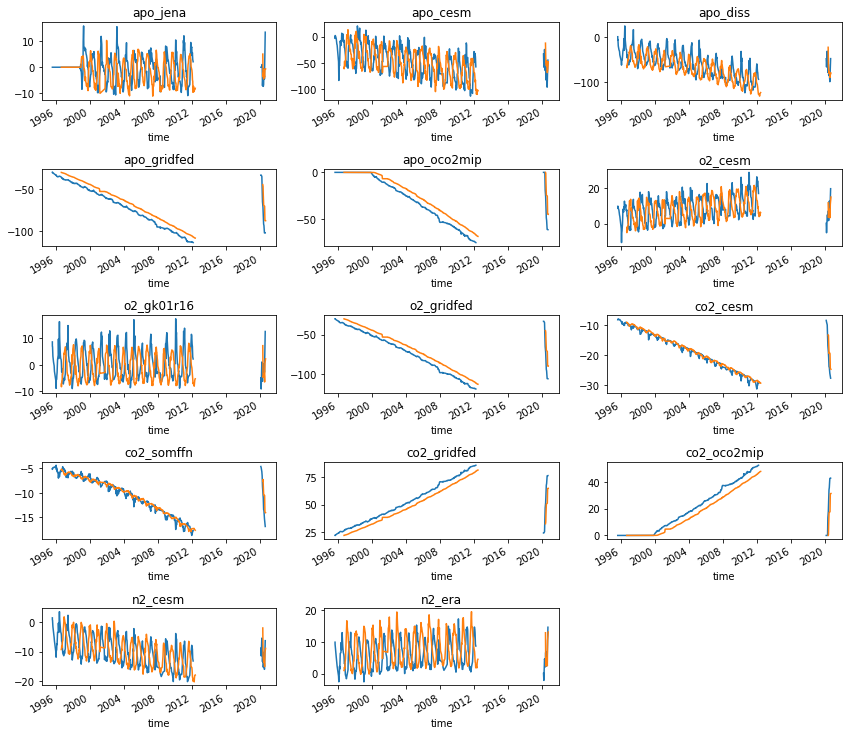

In [181]:
sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    df[v].plot(ax=ax)
    df2[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

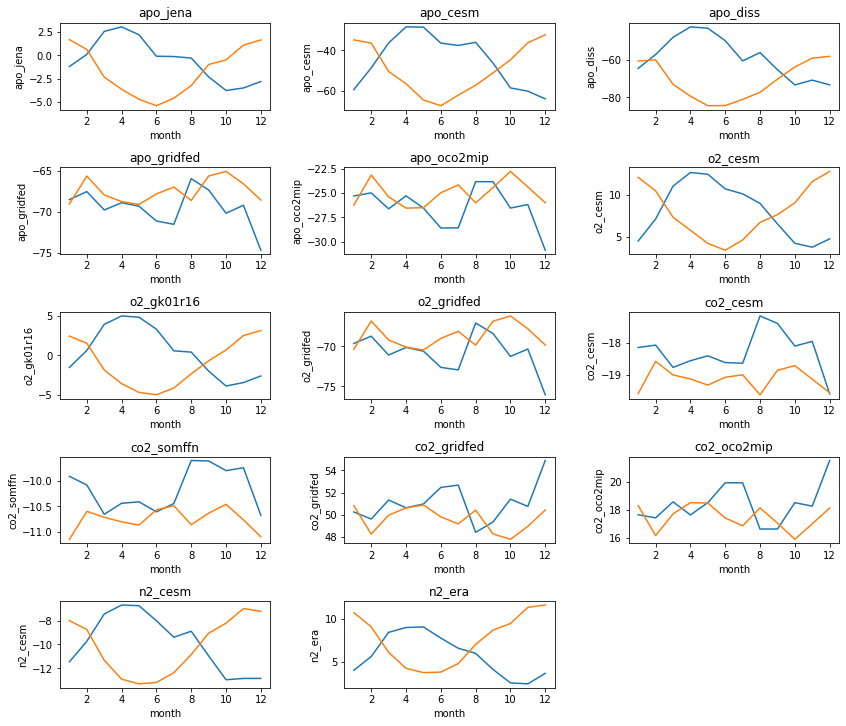

In [182]:
# seasonal climatology
ds = df.to_xarray()
ds_seas=ds.groupby('time.month').mean('time')
ds_seas['apo_cesm']

# kluge - need to make station name dynamic and allow any number of stations
ds2 = df2.to_xarray()
ds2_seas=ds2.groupby('time.month').mean('time')
ds2_seas['apo_cesm']


fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    ds_seas[v].plot(ax=ax)
    ds2_seas[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    